In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import xarray as xr

import regionmask

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
from scipy.interpolate import RectBivariateSpline
from datetime import datetime, timedelta

import glob

import sys
sys.path.append('../')
import grid_model as gridmod

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

# Data

## GEOS Chem Runs

Using egrid, NEI, and our model emissions inventories for NO, NO2, SO2

In [2]:
months_import = np.arange
ds_egrid_speciesconc = xr.open_mfdataset('../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_final-validation-egrid/OutputDir/GEOSChem.SpeciesConc.201605*.nc4',combine='by_coords')
ds_egrid_aerosolmass = xr.open_mfdataset('../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_final-validation-egrid/OutputDir/GEOSChem.AerosolMass.201605*.nc4',combine='by_coords')
ds_egrid = xr.merge([ds_egrid_aerosolmass, ds_egrid_speciesconc])
ds_egrid.attrs['name'] = 'egrid'

ds_NEI_speciesconc = xr.open_mfdataset('../../GCrundirs/type_NA-out_conc-yr_2016-gtropchem/merra2_05x0625_tropchem_na/OutputDir/GEOSChem.SpeciesConc.201605*.nc4',combine='by_coords')
ds_NEI_aerosolmass = xr.open_mfdataset('../../GCrundirs/type_NA-out_conc-yr_2016-gtropchem/merra2_05x0625_tropchem_na/OutputDir/GEOSChem.AerosolMass.201605*.nc4',combine='by_coords')
ds_NEI = xr.merge([ds_NEI_aerosolmass, ds_NEI_speciesconc])
ds_NEI.attrs['name'] = 'NEI'

ds_MODEL_speciesconc = xr.open_mfdataset('../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_final-validation/OutputDir/GEOSChem.SpeciesConc.201605*_0000z.nc4',combine='by_coords')
ds_MODEL_aerosolmass = xr.open_mfdataset('../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_final-validation/OutputDir/GEOSChem.AerosolMass.201605*_0000z.nc4',combine='by_coords')
ds_MODEL = xr.merge([ds_MODEL_aerosolmass, ds_MODEL_speciesconc])
ds_MODEL.attrs['name'] = 'MODEL'

datasets = [
    ds_NEI,
    ds_egrid,
    ds_MODEL
]

In [3]:
######### calculate NOx in our datasets #######
for d in datasets:
    d['SpeciesConc_NOx'] = (
        d['SpeciesConc_NO'] + d['SpeciesConc_NO2'] #sum our NO2 and NO to get NOx
                    ) 

######### put into one dataset and convert to ppbv ###########
ds=xr.Dataset() #create an empty dataset
conc_species = [ #create a list of the species we got from our species conc
    'NO',
    'NO2',
    'NOx',
    'SO2',
    'O3'
]

for d in datasets:
    for s in conc_species: #add all species to our dataset
        dname = d.attrs['name']
        ds[f'{dname}_{s}'] = d[f'SpeciesConc_{s}'] *1e9 #convert from mol/mol to ppbv
        ds[f'{dname}_{s}'].attrs['units'] = 'ppbv'
    ds[f'{dname}_PM25'] = d['PM25']
    ds[f'{dname}_PM25'].attrs['units'] = 'PM $\mu$g m$^{-3}$'
    
for s in conc_species:#calculate the differences
        ds[f'dif_MODEL-NEI_{s}'] = ds[f'MODEL_{s}']- ds[f'NEI_{s}'] 
        ds[f'dif_MODEL-NEI_{s}'].attrs['units'] = 'ppbv'
        
        ds[f'dif_MODEL-egrid_{s}'] = ds[f'MODEL_{s}']- ds[f'egrid_{s}'] 
        ds[f'dif_MODEL-egrid_{s}'].attrs['units'] = 'ppbv'
        
ds['dif_MODEL-NEI_PM25'] = ds['MODEL_PM25'] - ds['NEI_PM25']
ds['dif_MODEL-NEI_PM25'].attrs['units'] = 'PM $\mu$g m$^{-3}$'
        
ds['dif_MODEL-egrid_PM25'] = ds['MODEL_PM25'] - ds['egrid_PM25']
ds['dif_MODEL-egrid_PM25'].attrs['units'] = 'PM $\mu$g m$^{-3}$'
ds = ds.isel(lev = 0) #select surface level of data only
#ds #print the dataset

## EPA Observational data
data is from https://aqs.epa.gov/aqsweb/airdata/download_files.html
for the year 2016
choosing O3, NO, SO2, PM25 (FEM/FRM)


In [4]:
EPA_obs_df = pd.concat(map(pd.read_csv, glob.glob('../../GEOS_CHEM/obs_data/daily*.csv')))
EPA_obs_df['date'] = pd.to_datetime(EPA_obs_df['Date Local'])
EPA_obs_df['date'] = EPA_obs_df['date'].dt.normalize() + timedelta(hours=12)
EPA_obs_df['Longitude'] = np.round(EPA_obs_df['Longitude'], decimals = 8)
EPA_obs_df['Latitude'] = np.round(EPA_obs_df['Latitude'], decimals = 8)

EPA_obs_df = EPA_obs_df.drop(columns = ['State Code','County Code','Site Num','Parameter Code','POC','Datum','Sample Duration','Date Local', 'Event Type',
       'Observation Count', 'Observation Percent','1st Max Value', '1st Max Hour', 'Address', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change', 'Method Name'])

#only use the SO2 1 hour 2010 pollutant standard arithmetic means and drop the 3-hour 1971 arithmetic means
EPA_obs_df = EPA_obs_df.loc[~(EPA_obs_df['Pollutant Standard'] == 'SO2 3-hour 1971')]
EPA_obs_df = EPA_obs_df.rename(columns = {'Parameter Name':'species'})

#convert Ozone to ppb
EPA_obs_df.loc[EPA_obs_df['species'] == 'Ozone','Arithmetic Mean'] *= 1e3 #ppb


## Lists/Dicts of Variables

In [5]:
#define Lat and Lon of the nested grid US
lat_lon_dict = {
'US_lat_lon':[-140,-40,10,60],
'SE_lat_lon':[-90,-75,25,38],
'NW_lat_lon':[-125,-110,40,50],
'NE_lat_lon':[-90,-65,38,50],
'MW_lat_lon':[-110,-90,25,50]

}

levels_dict = {'PM25':np.arange(0., 20., .5), 'SO2':np.arange(0., 5., .1), 
               'NO2':np.arange(0., 5., .1), 'NOx':np.arange(0., 5., .1), 'O3':np.arange(0., 70., 1.),
               'dif':np.arange(-.3, .31, .01), 'regional_dif':np.arange(-1.5, 1.51, .01)}


species_dict = {'PM25':'PM2.5 - Local Conditions', 'SO2':'Sulfur dioxide', 'NO2':'Nitrogen dioxide (NO2)', 'O3':'Ozone', 'NOx':'Nitrogen Oxides (NO2+NO)'}
model_names = []
for d in datasets:    
    model_names.append(d.attrs['name'])



# Stats on Observations vs. Models

## Interpolate data to get GC run data at observational points

In [6]:
### interpolate data
interp_df = pd.DataFrame(columns=['Arithmetic Mean', 'Longitude', 'Latitude','model','species','date'])
months = '05'
for model in model_names:
    for species in list(species_dict.keys()):
        for time in EPA_obs_df.loc[EPA_obs_df.date.dt.month.isin([months])]['date'].unique():
            #lat and lon in radians
            lats = np.array(ds['lat'] *np.pi / 180) # in radians
            lons = np.array((360+ ds['lon'])*np.pi / 180) # in radians
            #data selected for date
            data = ds[f'{model}_{species}'].sel(time = time).squeeze()
            
            #new lat and lon in radians
            lats_new = EPA_obs_df.loc[(EPA_obs_df['species'] == species_dict[species]) & (EPA_obs_df.date.dt.month.isin([months]))]['Latitude'].unique()*np.pi / 180. # in radians
            lons_new = (360.+EPA_obs_df.loc[(EPA_obs_df['species'] == species_dict[species]) & (EPA_obs_df.date.dt.month.isin([months]))]['Longitude'].unique())*np.pi / 180. # in radians
            
            #interpolation function
            interp_spline= RectBivariateSpline(lats, lons, data)
            interp_data = interp_spline(lats_new,lons_new,grid = False)
            
            tmp_df = pd.DataFrame({'Arithmetic Mean':interp_data, 'Longitude':np.round((lons_new*180. / np.pi - 360.),decimals = 8), 'Latitude':np.round((lats_new*180. / np.pi),decimals = 8), 'model': model, 'species': species_dict[species], 'date': time})
            interp_df = interp_df.append(tmp_df, sort=False, ignore_index=True)

### merge EPA and interpolated dataframes

#create a sorted df of EPA data
sorted_EPA = EPA_obs_df.loc[
    (EPA_obs_df.date.dt.month.isin(['05']))
].sort_values(['Longitude','Latitude','species','date'])

#create a sorted df of interpolated data
sorted_interp = interp_df.sort_values(['Longitude','Latitude','model','species','date'])

#combine our sorted dataframes into one EPA/interpolated df based on lat, lon, species, date
EPA_interp_df = sorted_interp.merge(sorted_EPA, on = ['Latitude','Longitude','species','date'], how = 'right')
EPA_interp_df = EPA_interp_df.rename(columns = {'Arithmetic Mean_x':'GC Daily Mean','Arithmetic Mean_y':'EPA Daily Mean'})

#create a column of the difference between EPA and interpolated data
EPA_interp_df['GC-EPA Daily Mean'] = EPA_interp_df['GC Daily Mean'].loc[EPA_interp_df['EPA Daily Mean']>.1] - EPA_interp_df['EPA Daily Mean'].loc[EPA_interp_df['EPA Daily Mean']>.1]
EPA_interp_df['GC-EPA Daily Mean Percent Difference'] = (EPA_interp_df['GC-EPA Daily Mean']/EPA_interp_df['EPA Daily Mean'].loc[EPA_interp_df['EPA Daily Mean']>.1])*100


### create a dataframe grouped by species, model and site name
EPA_interp_mean_state_df = EPA_interp_df.groupby(['species','model','State Name']).mean()
EPA_interp_mean_site_df = EPA_interp_df.groupby(['species','model','Local Site Name']).mean()

# Plots 

## Differences between Observations and each GC Run

### Define variables and lists

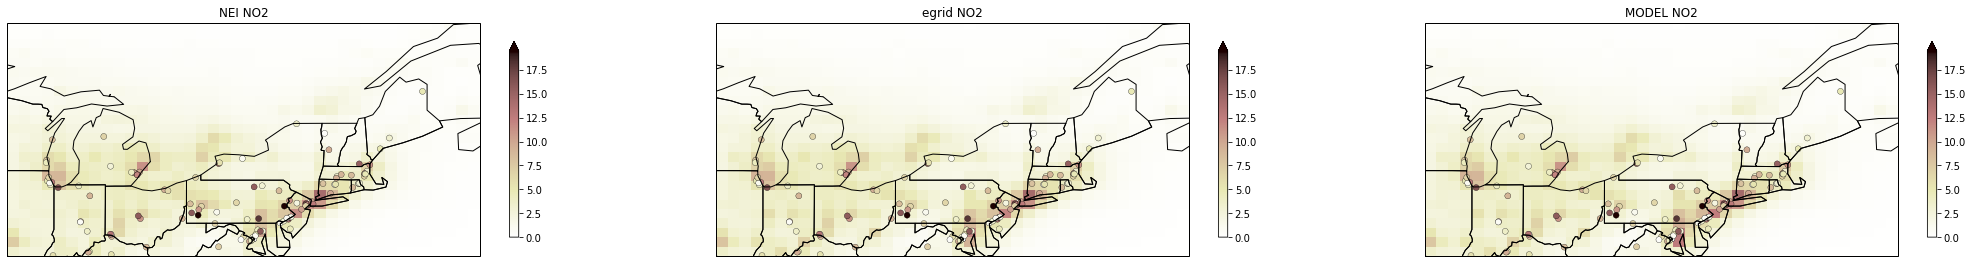

In [14]:
gridmod.obs_model_plot(ds = ds, df = EPA_obs_df, species = 'NO2',model_names = model_names,
               cmap = 'pink_r', figsize = [36,12],month = 5,
               vmin = levels_dict['PM25'].min(), vmax = levels_dict['PM25'].max(), 
               rows = 1, columns = 3, lat_lon = lat_lon_dict['NE_lat_lon'])

In [ ]:
gridmod.concentration_plot(ds, species = 'PM25', model_names = model_names, season = 'SON',
                   rows = 1, columns = 3, lat_lon = lat_lon_dict['US_lat_lon'],
                    levels = levels_dict['O3'],figsize = [24,8])

## Scatterplots of interpolation

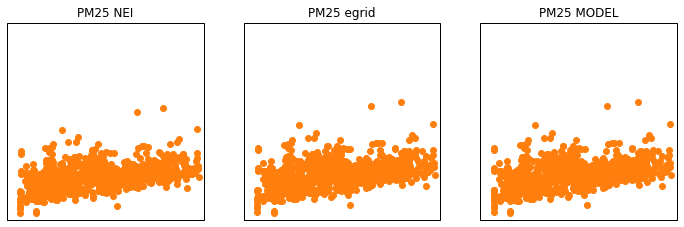

In [15]:
for i in range(2):
    for j in range(3):
        ax[i, j].text(0.5, 0.5, str((i, j)),
                      fontsize=18, ha='center')
fig

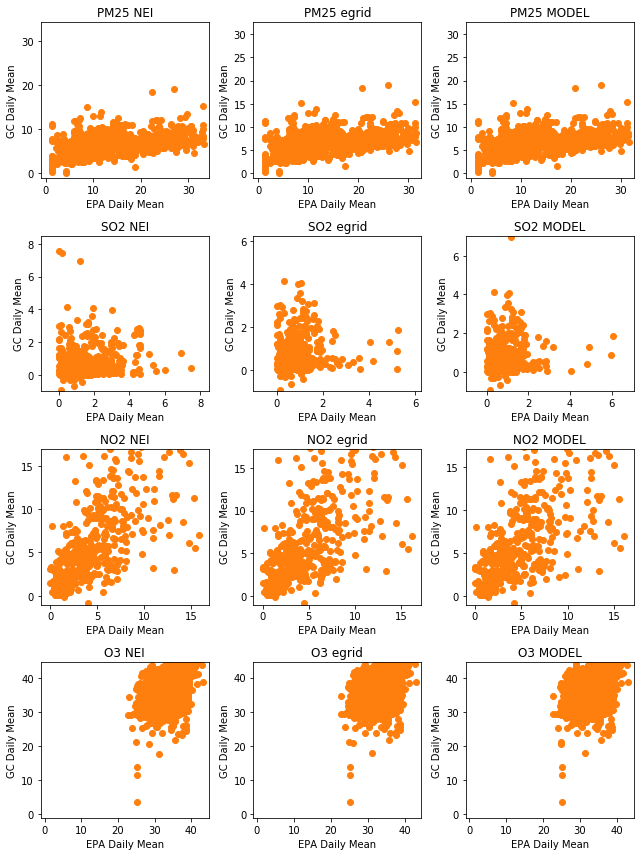

In [30]:
fig, axes = plt.subplots(4,3,figsize = [9,12])
for idx_s, species in enumerate(['PM25', 'SO2', 'NO2', 'O3']):
    for idx_m, model in enumerate(model_names):
        ax = axes[idx_s,idx_m]
        x = interp_df.loc[(interp_df['model'] == model) & (interp_df['species'] == species_dict[species])].groupby(['Latitude','Longitude']).mean()['Arithmetic Mean']
        y = EPA_obs_df.loc[(EPA_obs_df['species'] == species_dict[species]) & (EPA_obs_df.date.dt.month.isin(['05']))].groupby(['Latitude','Longitude']).mean()['Arithmetic Mean']
        ax.scatter(x, y, c = 'C1')
        ax.set_xlabel('EPA Daily Mean')
        ax.set_ylabel('GC Daily Mean')
        ax.set_xlim([-1,x.max()+1])
        ax.set_ylim([-1,x.max()+1])
        ax.set_title(f'{species} {model}')
plt.tight_layout()

In [35]:
def loc_mean_plot(df, species_list = ['PM25', 'SO2', 'NO2', 'O3']):
    for species in species_list:
        fig = plt.figure(figsize = [20,5])
        plt.bar(df.loc[species_dict[species],'MODEL'].index.values,
                 df.loc[species_dict[species],'MODEL']['GC-EPA Daily Mean Percent Difference'], 
                 width = .3, align="edge",
                label = 'MODEL')
        plt.bar(df.loc[species_dict[species],'egrid'].index.values,
             df.loc[species_dict[species],'egrid']['GC-EPA Daily Mean Percent Difference'], 
             width = -.3, align="edge",
            label = 'egrid')
        plt.bar(df.loc[species_dict[species],'NEI'].index.values,
         df.loc[species_dict[species],'NEI']['GC-EPA Daily Mean Percent Difference'], 
         width = .3, align="center",
        label = 'NEI')
        plt.xticks(rotation = 45, fontsize = 10);
        plt.xlabel('State')
        plt.ylabel('% Difference')
        plt.legend()
        plt.title(f'{species} Average % Difference between Models and EPA Observations')

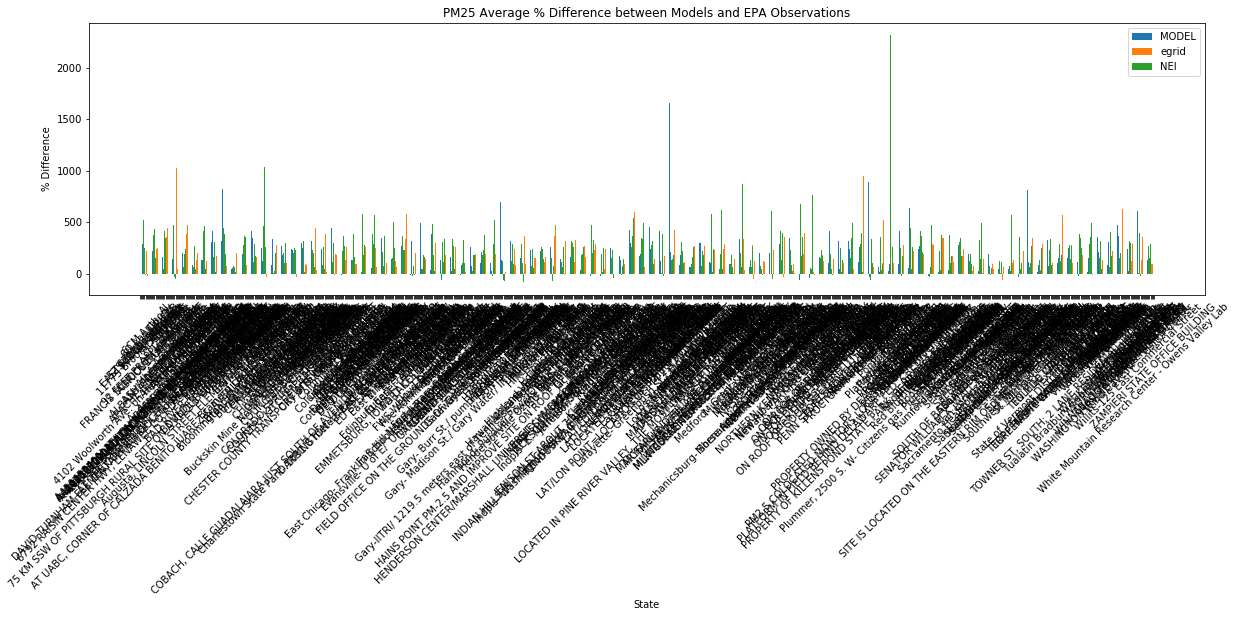

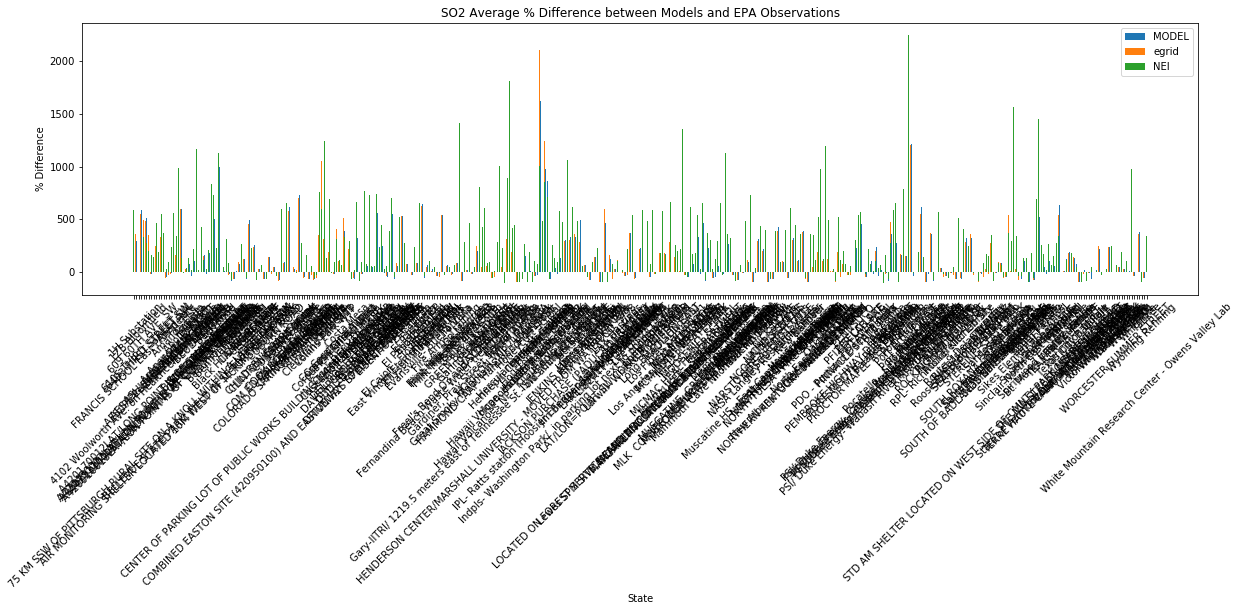

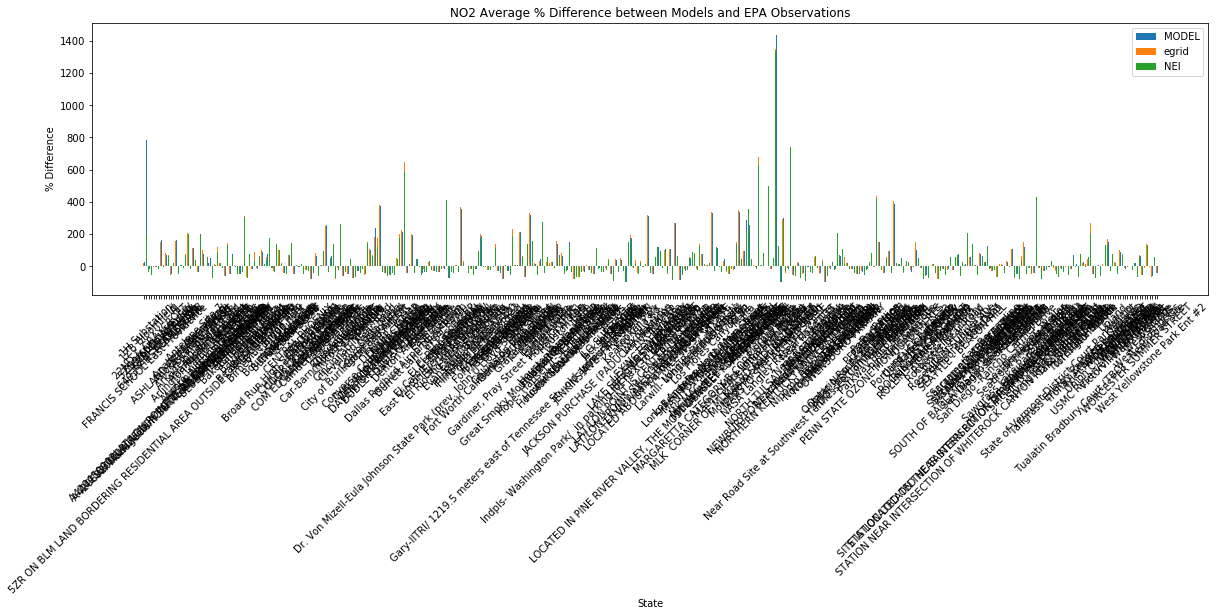

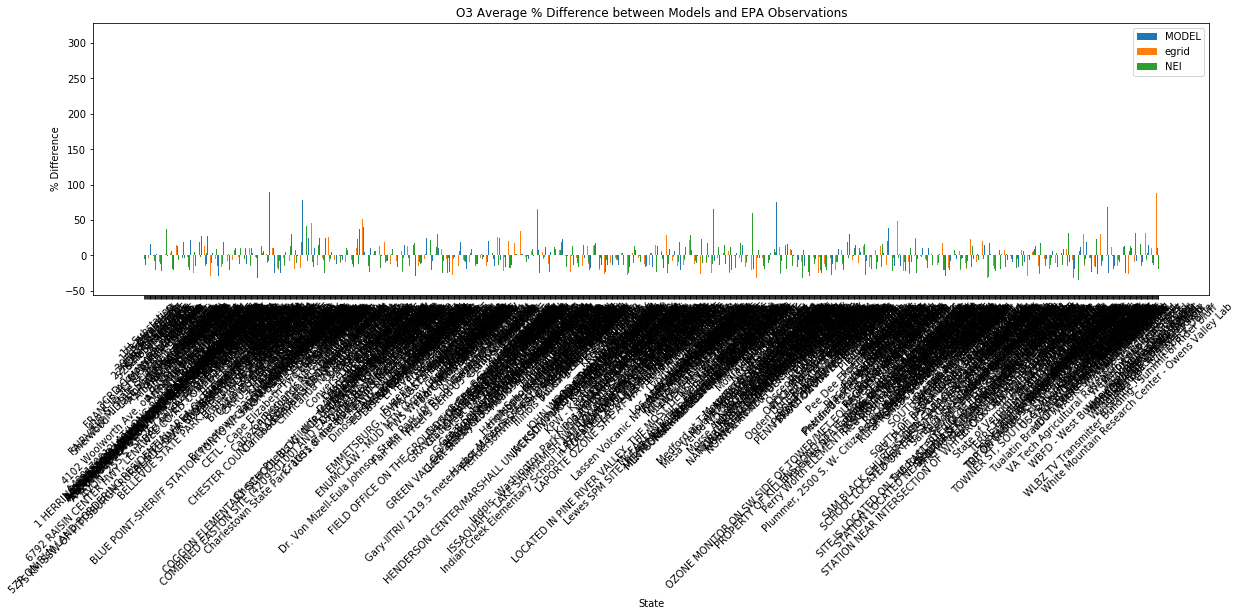

In [68]:
loc_mean_plot(EPA_interp_mean_site_df)

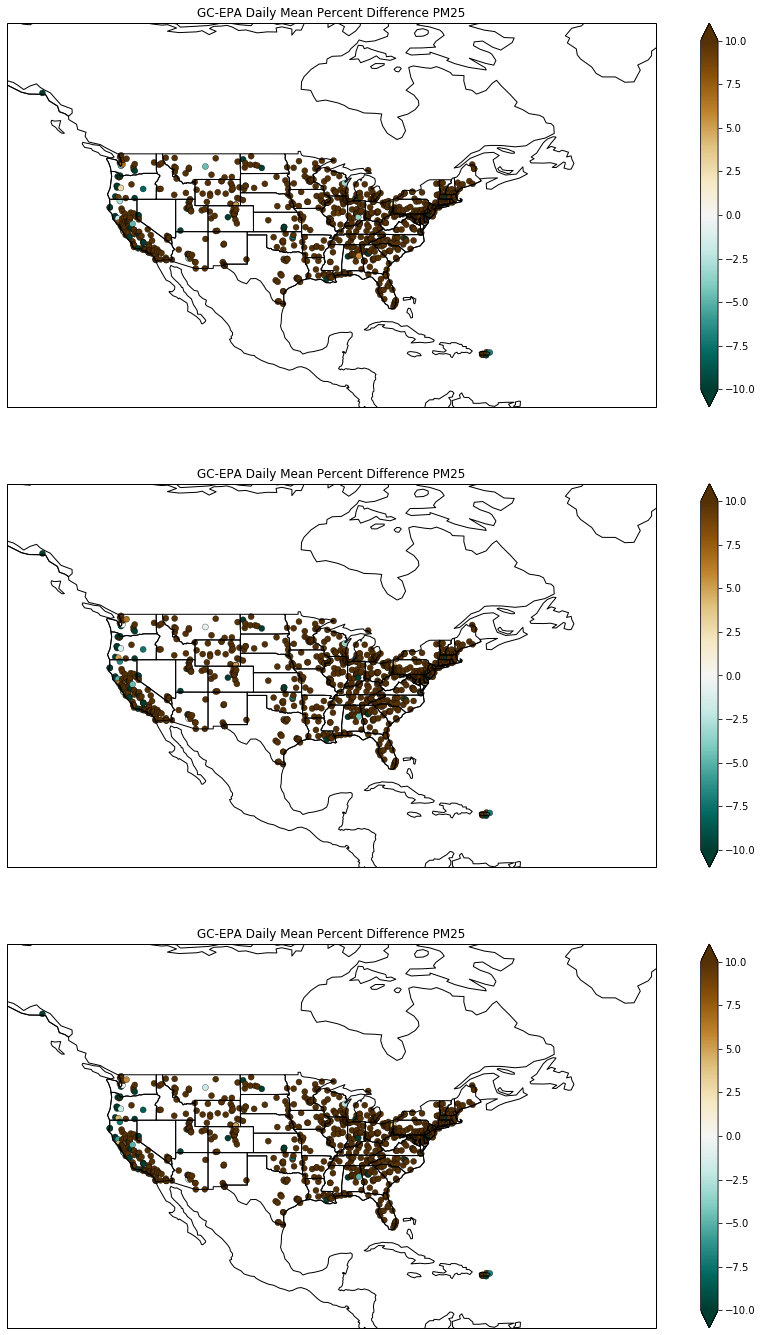

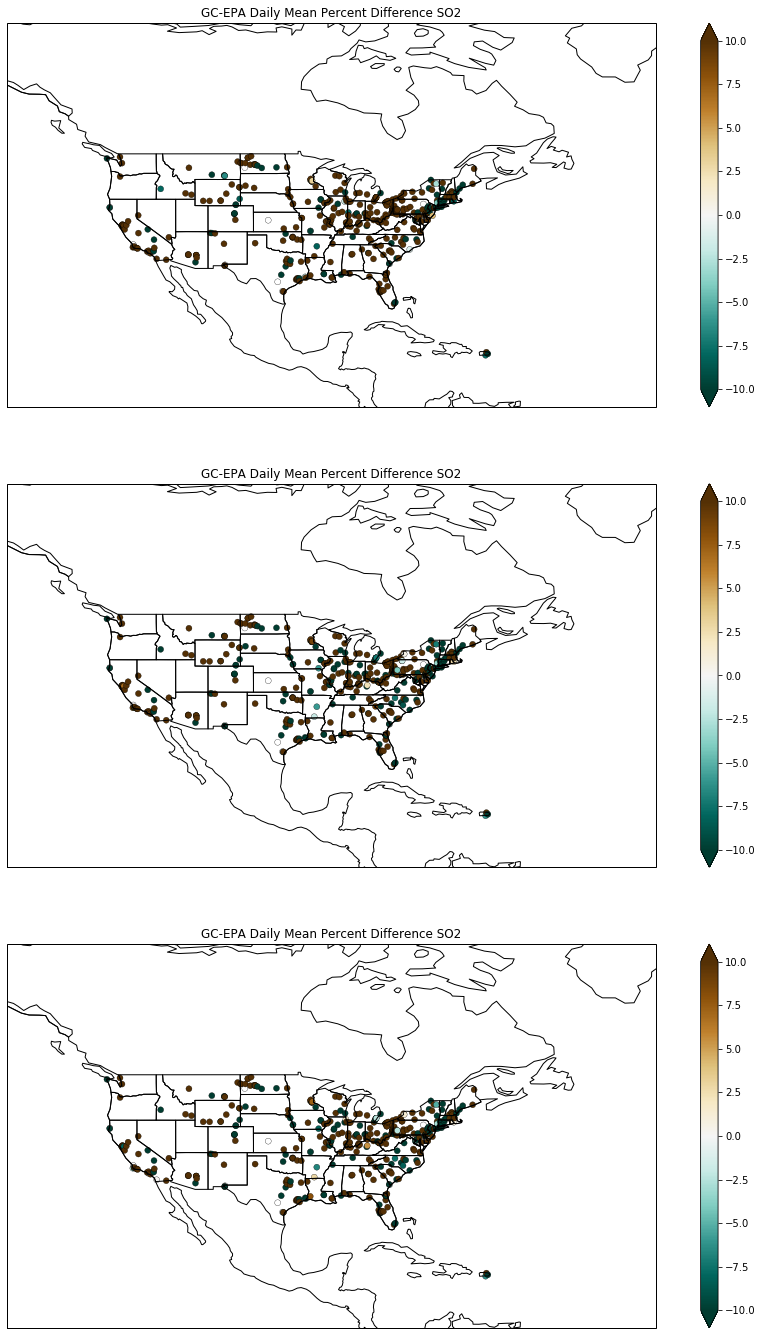

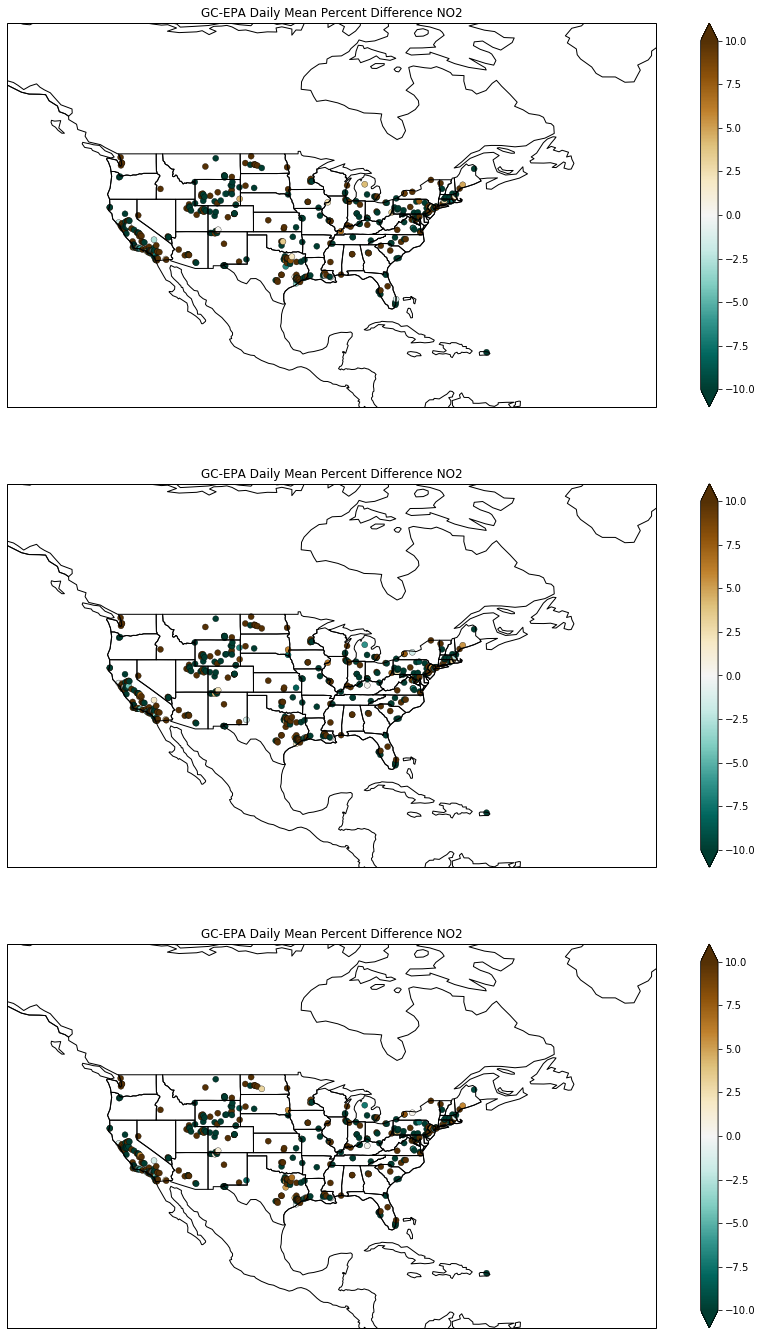

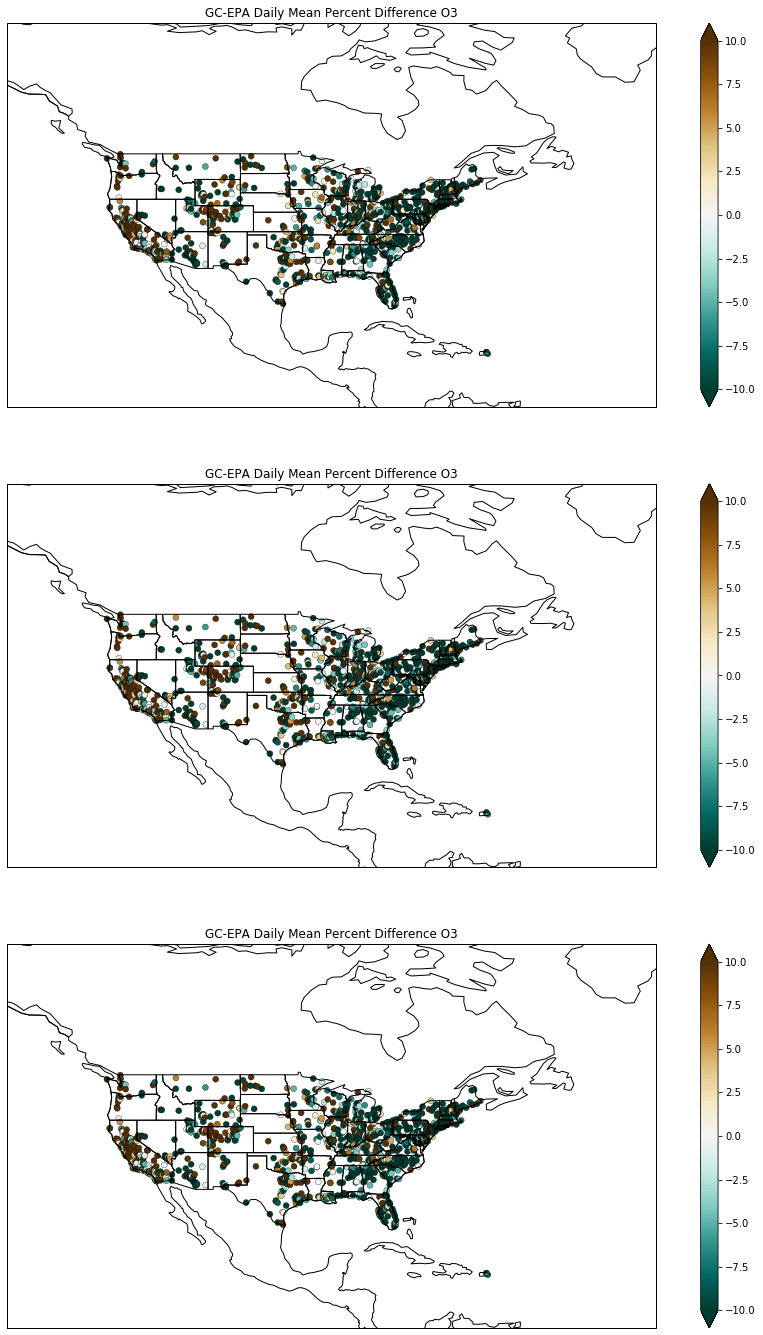

In [69]:
for species in ['PM25', 'SO2', 'NO2', 'O3']:
    gridmod.EPA_interp_dif_plot(EPA_interp_df, species = species, model_names = model_names, difference_parameter = 'GC-EPA Daily Mean Percent Difference',
                           vmin = -10, vmax = 10, rows = 3, columns = 1, cmap = 'BrBG_r', figsize = [16,24], 
                            lat_lon = lat_lon_dict['US_lat_lon'])

## max differences in PM in model and standard runs
#### PROBLEM: WHY IS THE MODEL-NEI PM25 not working!!?

print('max difference in PM model- egrid '+ str(ds['dif_MODEL-egrid_PM25'].max().values) + ' and min ' + str(ds['dif_MODEL-egrid_PM25'].min().values))
print('max difference in PM model- NEI '+ str(ds['dif_MODEL-NEI_PM25'].max().values) + ' and min ' + str(ds['dif_MODEL-NEI_PM25'].min().values))

print('max difference in O3 model- egrid '+ str(ds['dif_MODEL-egrid_O3'].max().values) + ' and min ' + str(ds['dif_MODEL-egrid_O3'].min().values))
print('max difference in O3 model- NEI '+ str(ds['dif_MODEL-NEI_O3'].max().values) + ' and min ' + str(ds['dif_MODEL-NEI_O3'].min().values))
